In [1]:
import tensorflow as tf

_CHR_IDX = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]


@tf.keras.utils.register_keras_serializable(package="Text")
class DenseEinsum(tf.keras.layers.Layer):
  """A densely connected layer that uses tf.einsum as the backing computation.

  This layer can perform einsum calculations of arbitrary dimensionality.

  Arguments:
    output_shape: Positive integer or tuple, dimensionality of the output space.
    num_summed_dimensions: The number of dimensions to sum over. Standard 2D
      matmul should use 1, 3D matmul should use 2, and so forth.
    activation: Activation function to use. If you don't specify anything, no
      activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to the `kernel` weights
      matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to the output of the
      layer (its "activation")..
    kernel_constraint: Constraint function applied to the `kernel` weights
      matrix.
    bias_constraint: Constraint function applied to the bias vector.
  Input shape:
    N-D tensor with shape: `(batch_size, ..., input_dim)`. The most common
      situation would be a 2D input with shape `(batch_size, input_dim)`.
  Output shape:
    N-D tensor with shape: `(batch_size, ..., units)`. For instance, for a 2D
      input with shape `(batch_size, input_dim)`, the output would have shape
      `(batch_size, units)`.
  """

  def __init__(self,
               output_shape,
               num_summed_dimensions=1,
               activation=None,
               use_bias=True,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(DenseEinsum, self).__init__(**kwargs)
    self._output_shape = output_shape if isinstance(
        output_shape, (list, tuple)) else (output_shape,)
    self._activation = tf.keras.activations.get(activation)
    self._use_bias = use_bias
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._bias_initializer = tf.keras.initializers.get(bias_initializer)
    self._kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
    self._bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
    self._kernel_constraint = tf.keras.constraints.get(kernel_constraint)
    self._bias_constraint = tf.keras.constraints.get(bias_constraint)
    self._num_summed_dimensions = num_summed_dimensions
    self._einsum_string = None

  def _build_einsum_string(self, free_input_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    letter_offset = 0
    for i in range(free_input_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      output_str += char

    letter_offset += free_input_dims
    for i in range(bound_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
      char = _CHR_IDX[i + letter_offset]
      kernel_str += char
      output_str += char

    return input_str + "," + kernel_str + "->" + output_str

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    input_rank = input_shape.rank
    free_input_dims = input_rank - self._num_summed_dimensions
    output_dims = len(self._output_shape)

    self._einsum_string = self._build_einsum_string(free_input_dims,
                                                    self._num_summed_dimensions,
                                                    output_dims)

    # This is only saved for testing purposes.
    self._kernel_shape = (
        input_shape[free_input_dims:].concatenate(self._output_shape))

    self._kernel = self.add_weight(
        "kernel",
        shape=self._kernel_shape,
        initializer=self._kernel_initializer,
        regularizer=self._kernel_regularizer,
        constraint=self._kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self._use_bias:
      self._bias = self.add_weight(
          "bias",
          shape=self._output_shape,
          initializer=self._bias_initializer,
          regularizer=self._bias_regularizer,
          constraint=self._bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self._bias = None
    super(DenseEinsum, self).build(input_shape)

  def get_config(self):
    config = {
        "output_shape":
            self._output_shape,
        "num_summed_dimensions":
            self._num_summed_dimensions,
        "activation":
            tf.keras.activations.serialize(self._activation),
        "use_bias":
            self._use_bias,
        "kernel_initializer":
            tf.keras.initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            tf.keras.initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            tf.keras.regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            tf.keras.regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            tf.keras.regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            tf.keras.constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            tf.keras.constraints.serialize(self._bias_constraint)
    }
    base_config = super(DenseEinsum, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, inputs):
    ret = tf.einsum(self._einsum_string, inputs, self._kernel)
    if self._use_bias:
      ret += self._bias
    if self._activation is not None:
      ret = self._activation(ret)
    return ret

In [2]:
import math
import numpy as np
import tensorflow as tf

BIG_CONSTANT = 1e8


def create_projection_matrix(m, d, seed=0, scaling=0, struct_mode=False):
  r"""Constructs the matrix of random projections.

  Constructs a matrix of random orthogonal projections. Each projection vector
  has direction chosen uniformly at random and either deterministic length
  \sqrt{d} or length taken from the \chi(d) distribution (in the latter case
  marginal distributions of the projections are d-dimensional Gaussian vectors
  with associated identity covariance matrix).

  Args:
    m: number of random projections.
    d: dimensionality of each random projection.
    seed: random seed used to construct projections.
    scaling: 1 if all the random projections need to be renormalized to have
      length \sqrt{d}, 0 if the lengths of random projections should follow
      \chi(d) distribution.
    struct_mode: if True then products of Givens rotations will be used to
      construct random orthogonal matrix. This bypasses Gram-Schmidt
      orthogonalization.

  Returns:
    The matrix of random projections of the shape [m, d].
  """
  nb_full_blocks = int(m / d)
  block_list = []
  current_seed = seed
  for _ in range(nb_full_blocks):
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q)
    current_seed += 1
  remaining_rows = m - nb_full_blocks * d
  if remaining_rows > 0:
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q[0:remaining_rows])
  final_matrix = tf.experimental.numpy.vstack(block_list)
  current_seed += 1

  if scaling == 0:
    multiplier = tf.norm(tf.random.normal((m, d), seed=current_seed), axis=1)
  elif scaling == 1:
    multiplier = tf.math.sqrt(float(d)) * tf.ones((m))
  else:
    raise ValueError("Scaling must be one of {0, 1}. Was %s" % scaling)

  return tf.linalg.matmul(tf.linalg.diag(multiplier), final_matrix)


def create_products_of_givens_rotations(dim, seed):
  r"""Constructs a 2D-tensor which is a product of Givens random rotations.

  Constructs a 2D-tensor of the form G_1 * ... * G_k, where G_i is a Givens
  random rotation. The resulting tensor mimics a matrix taken uniformly at
  random form the orthogonal group.

  Args:
    dim: number of rows/columns of the resulting 2D-tensor.
    seed: random seed.

  Returns:
    The product of Givens random rotations.
  """
  nb_givens_rotations = dim * int(math.ceil(math.log(float(dim))))
  q = np.eye(dim, dim)
  np.random.seed(seed)
  for _ in range(nb_givens_rotations):
    random_angle = math.pi * np.random.uniform()
    random_indices = np.random.choice(dim, 2)
    index_i = min(random_indices[0], random_indices[1])
    index_j = max(random_indices[0], random_indices[1])
    slice_i = q[index_i]
    slice_j = q[index_j]
    new_slice_i = math.cos(random_angle) * slice_i + math.sin(
        random_angle) * slice_j
    new_slice_j = -math.sin(random_angle) * slice_i + math.cos(
        random_angle) * slice_j
    q[index_i] = new_slice_i
    q[index_j] = new_slice_j
  return tf.cast(tf.constant(q), dtype=tf.float32)


def relu_kernel_transformation(data,
                               is_query,
                               projection_matrix=None,
                               numerical_stabilizer=0.001):
  """Computes features for the ReLU-kernel.

  Computes random features for the ReLU kernel from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  del is_query
  if projection_matrix is None:
    return tf.nn.relu(data) + numerical_stabilizer
  else:
    ratio = 1.0 / tf.math.sqrt(
        tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
    data_dash = ratio * tf.einsum("blhd,md->blhm", data, projection_matrix)
    return tf.nn.relu(data_dash) + numerical_stabilizer


def softmax_kernel_transformation(data,
                                  is_query,
                                  projection_matrix=None,
                                  numerical_stabilizer=0.000001):
  """Computes random features for the softmax kernel using FAVOR+ mechanism.

  Computes random features for the softmax kernel using FAVOR+ mechanism from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  data_normalizer = 1.0 / (
      tf.math.sqrt(tf.math.sqrt(tf.dtypes.cast(data.shape[-1], tf.float32))))
  data = data_normalizer * data
  ratio = 1.0 / tf.math.sqrt(
      tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
  data_dash = tf.einsum("blhd,md->blhm", data, projection_matrix)
  diag_data = tf.math.square(data)
  diag_data = tf.math.reduce_sum(
      diag_data, axis=tf.keras.backend.ndim(data) - 1)
  diag_data = diag_data / 2.0
  diag_data = tf.expand_dims(diag_data, axis=tf.keras.backend.ndim(data) - 1)
  last_dims_t = (len(data_dash.shape) - 1,)
  attention_dims_t = (len(data_dash.shape) - 3,)
  if is_query:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t, keepdims=True)) + numerical_stabilizer)
  else:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t + attention_dims_t, keepdims=True)) +
        numerical_stabilizer)

  return data_dash


def noncausal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR noncausal attention AV.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR noncausal attention AV.
  """
  kvs = tf.einsum("lbhm,lbhd->bhmd", ks, vs)
  return tf.einsum("lbhm,bhmd->lbhd", qs, kvs)


def noncausal_denominator(qs, ks):
  """Computes FAVOR normalizer in noncausal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in noncausal attention.
  """
  all_ones = tf.ones([ks.shape[0]])
  ks_sum = tf.einsum("lbhm,l->bhm", ks, all_ones)
  return tf.einsum("lbhm,bhm->lbh", qs, ks_sum)


@tf.custom_gradient
def causal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR causal attention A_{masked}V.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR causal attention A_{masked}V.
  """

  result = []
  sums = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

  for index in range(qs.shape[0]):
    sums = sums + tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    grads = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

    gr_sums = sums

    q_grads = []
    k_grads = []
    v_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijkl,ijl->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      grads = grads + tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index])
      k_grads.append(tf.einsum("ijkl,ijl->ijk", grads, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", grads, ks[index])[None, Ellipsis])
      gr_sums = gr_sums - tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)
    v_grads = tf.concat(v_grads[::-1], axis=0)

    return q_grads, k_grads, v_grads

  return result, grad


@tf.custom_gradient
def causal_denominator(qs, ks):
  """Computes FAVOR normalizer in causal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in causal attention.
  """

  result = []
  sums = tf.zeros_like(ks[0])

  for index in range(qs.shape[0]):
    sums = sums + ks[index]
    result.append(tf.reduce_sum(qs[index] * sums, axis=2)[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    k_grad = tf.zeros_like(ks[0])

    gr_sums = sums

    q_grads = []
    k_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijk,ij->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      k_grad = k_grad + tf.einsum("ijk,ij->ijk", qs[index], res_grad[index])
      k_grads.append(k_grad[None, Ellipsis])
      gr_sums = gr_sums - ks[index]

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)

    return q_grads, k_grads

  return result, grad


def favor_attention(query,
                    key,
                    value,
                    kernel_transformation,
                    causal,
                    projection_matrix=None):
  """Computes FAVOR normalized attention.

  Args:
    query: query tensor.
    key: key tensor.
    value: value tensor.
    kernel_transformation: transformation used to get finite kernel features.
    causal: whether attention is causal or not.
    projection_matrix: projection matrix to be used.

  Returns:
    FAVOR normalized attention.
  """
  query_prime = kernel_transformation(query, True,
                                      projection_matrix)  # [B,L,H,M]
  key_prime = kernel_transformation(key, False, projection_matrix)  # [B,L,H,M]
  query_prime = tf.transpose(query_prime, [1, 0, 2, 3])  # [L,B,H,M]
  key_prime = tf.transpose(key_prime, [1, 0, 2, 3])  # [L,B,H,M]
  value = tf.transpose(value, [1, 0, 2, 3])  # [L,B,H,D]

  if causal:
    av_attention = causal_numerator(query_prime, key_prime, value)
    attention_normalizer = causal_denominator(query_prime, key_prime)
  else:
    av_attention = noncausal_numerator(query_prime, key_prime, value)
    attention_normalizer = noncausal_denominator(query_prime, key_prime)
  # TODO(kchoro): Add more comments.
  av_attention = tf.transpose(av_attention, [1, 0, 2, 3])
  attention_normalizer = tf.transpose(attention_normalizer, [1, 0, 2])
  attention_normalizer = tf.expand_dims(attention_normalizer,
                                        len(attention_normalizer.shape))
  return av_attention / attention_normalizer


class Attention(tf.keras.layers.Layer):
  """Multi-headed attention layer."""

  def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=relu_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type=None,
               nb_random_features=0):
    """Initialize Attention.

    Args:
      hidden_size: int, output dim of hidden layer.
      num_heads: int, number of heads to repeat the same attention structure.
      attention_dropout: float, dropout rate inside attention for training.
      kernel_transformation: transformation used to produce kernel features for
        attention.
      numerical_stabilizer: used to bound away from zero kernel values.
      causal: whether attention is causal or not.
      projection_matrix_type: None if Identity should be used, otherwise random
        projection matrix will be applied.
      nb_random_features: number of random features to be used (relevant only if
        projection_matrix is not None).
    """
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

  def build(self, input_shape):
    """Builds the layer."""
    # Layers for linearly projecting the queries, keys, and values.
    size_per_head = self.hidden_size // self.num_heads

    def _glorot_initializer(fan_in, fan_out):
      limit = math.sqrt(6.0 / (fan_in + fan_out))
      return tf.keras.initializers.RandomUniform(minval=-limit, maxval=limit)

    attention_initializer = _glorot_initializer(input_shape.as_list()[-1],
                                                self.hidden_size)
    self.query_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="query")
    self.key_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="key")
    self.value_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="value")

    output_initializer = _glorot_initializer(self.hidden_size, self.hidden_size)
    self.output_dense_layer = DenseEinsum(
        output_shape=self.hidden_size,
        num_summed_dimensions=2,
        kernel_initializer=output_initializer,
        use_bias=False,
        name="output_transform")
    super(Attention, self).build(input_shape)

  def get_config(self):
    return {
        "hidden_size": self.hidden_size,
        "num_heads": self.num_heads,
        "attention_dropout": self.attention_dropout,
    }

  def call(self,
           query_input,
           source_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    """Apply attention mechanism to query_input and source_input.

    Args:
      query_input: A tensor with shape [batch_size, length_query, hidden_size].
      source_input: A tensor with shape [batch_size, length_source,
        hidden_size].
      bias: A tensor with shape [batch_size, 1, length_query, length_source],
        the attention bias that will be added to the result of the dot product.
      training: A bool, whether in training mode or not.
      cache: (Used during prediction) A dictionary with tensors containing
        results of previous attentions. The dictionary must have the items:
            {"k": tensor with shape [batch_size, i, heads, dim_per_head],
             "v": tensor with shape [batch_size, i, heads, dim_per_head]} where
               i is the current decoded length for non-padded decode, or max
               sequence length for padded decode.
      decode_loop_step: An integer, step number of the decoding loop. Used only
        for autoregressive inference on TPU.

    Returns:
      Attention layer output with shape [batch_size, length_query, hidden_size]
    """
    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
    else:
      dim = query.shape[-1]
      seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      seed = tf.dtypes.cast(seed, tf.int32)
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim, seed=seed)

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output


class SelfAttention(Attention):
  """Multiheaded self-attention layer."""

  def call(self,
           query_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    return super(SelfAttention, self).call(query_input, query_input, bias,
                                           training, cache, decode_loop_step)

In [3]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, image_size, patch_size, dim, channels=3):
        """
        Args:
            image_size (int): 输入图像的边长 (假设是正方形)。
            patch_size (int): 每个图像块的边长 (假设是正方形)。
            dim (int): 投影后的嵌入维度。
            channels (int): 输入图像的通道数，默认为 3（RGB）。
        """
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2  # 每张图像包含的图像块数量
        self.dim = dim

        # 使用卷积层模拟图像块的线性投影
        self.conv = tf.keras.layers.Conv2D(
            filters=dim,  # 投影后的嵌入维度
            kernel_size=patch_size,  # 卷积核大小等于图像块大小
            strides=patch_size,  # 步幅等于图像块大小
            padding="valid",
            name="patch_embedding"
        )

    def call(self, x):
        """
        Args:
            x (Tensor): 输入图像张量，形状为 (batch_size, image_size, image_size, channels)。
        Returns:
            Tensor: 嵌入后的图像块序列，形状为 (batch_size, num_patches, dim)。
        """
        # 卷积操作后，输出形状为 (batch_size, num_patches_height, num_patches_width, dim)
        x = self.conv(x)

        # 展平图像块，输出形状为 (batch_size, num_patches, dim)
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, [batch_size, self.num_patches, self.dim])
        return x


In [4]:

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, num_patches, dim, learnable=True):
        """
        Args:
            num_patches (int): 图像块的数量。
            dim (int): 嵌入维度。
            learnable (bool): 是否使用可学习的位置编码，默认为 True。
        """
        super().__init__()
        self.num_patches = num_patches
        self.dim = dim
        self.learnable = learnable

        if learnable:
            # 使用可训练的位置编码
            self.position_embedding = tf.Variable(
                initial_value=tf.random.normal([1, num_patches, dim]),
                trainable=True,
                name="position_embedding"
            )
        else:
            # 使用固定的正弦-余弦编码
            self.position_embedding = self._generate_sincos_positional_encoding()

    def _generate_sincos_positional_encoding(self):
        """
        生成固定的正弦-余弦位置编码。
        Returns:
            Tensor: 位置编码张量，形状为 (1, num_patches, dim)。
        """
        position = tf.cast(tf.range(self.num_patches)[:, tf.newaxis], tf.float32)  # 将 position 转为 float32
        div_term = tf.exp(tf.range(0, self.dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / self.dim))  # dim/2

        pos_enc = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)
        pos_enc = tf.reshape(pos_enc, [1, self.num_patches, self.dim])  # (1, num_patches, dim)
        return tf.Variable(pos_enc, trainable=False, name="fixed_position_embedding")

    def call(self, x):
        """
        Args:
            x (Tensor): 图像块嵌入张量，形状为 (batch_size, num_patches, dim)。
        Returns:
            Tensor: 添加了位置编码的张量，形状为 (batch_size, num_patches, dim)。
        """
        return x + self.position_embedding


In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, mlp_dim, attention_dropout=0.1, ff_dropout=0.1, nb_random_features=256):
        """
        Args:
            dim (int): 输入和输出的嵌入维度。
            num_heads (int): 多头注意力的头数。
            mlp_dim (int): 前馈网络隐藏层的维度。
            attention_dropout (float): 注意力层的 Dropout 概率。
            ff_dropout (float): 前馈网络的 Dropout 概率。
            nb_random_features (int): FAVOR+ 的随机特征数量。
        """
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim

        
        # FAVOR+ 自定义注意力机制
        self.attention = Attention(
            hidden_size=dim,
            num_heads=num_heads,
            attention_dropout=attention_dropout,
            kernel_transformation=relu_kernel_transformation,
            nb_random_features=nb_random_features,
            causal=False,
        )

        # 残差连接和层归一化（Attention）
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attention_dropout = tf.keras.layers.Dropout(attention_dropout)

        # 前馈神经网络
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation="gelu"),
            tf.keras.layers.Dropout(ff_dropout),
            tf.keras.layers.Dense(dim),
            tf.keras.layers.Dropout(ff_dropout),
        ])

        # 残差连接和层归一化（FFN）
        self.ffn_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        """
        Args:
            x (Tensor): 输入张量，形状为 (batch_size, num_patches, dim)。
            training (bool): 是否处于训练模式。
        Returns:
            Tensor: 经过 Transformer Block 处理的张量，形状为 (batch_size, num_patches, dim)。
        """
        # 多头注意力层 (基于 FAVOR+)
        attn_output = self.attention(query_input=x, source_input=x, bias=None, training=training)
        attn_output = self.attention_dropout(attn_output, training=training)
        x = self.attention_norm(x + attn_output)  # 残差连接 + 层归一化

        # 前馈神经网络层
        ffn_output = self.ffn(x, training=training)
        x = self.ffn_norm(x + ffn_output)  # 残差连接 + 层归一化

        return x


In [6]:
import tensorflow as tf

class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, num_heads, mlp_dim, channels=3, attention_dropout=0.1, ff_dropout=0.1, nb_random_features=256):
        """
        Args:
            image_size (int): 输入图像的边长（假设正方形图像）。
            patch_size (int): 图像块的边长。
            num_classes (int): 分类类别数。
            dim (int): 嵌入维度。
            depth (int): Transformer Block 的层数。
            num_heads (int): 多头注意力的头数。
            mlp_dim (int): 前馈网络隐藏层的维度。
            channels (int): 图像通道数（默认为 3，RGB）。
            attention_dropout (float): 注意力层的 Dropout 概率。
            ff_dropout (float): 前馈网络的 Dropout 概率。
            nb_random_features (int): FAVOR+ 的随机特征数量。
        """
        super().__init__()

        # 图像块嵌入模块
        self.patch_embedding = PatchEmbedding(image_size=image_size, patch_size=patch_size, dim=dim, channels=channels)

        # 位置编码模块（固定编码）
        self.positional_encoding = PositionalEncoding(num_patches=self.patch_embedding.num_patches, dim=dim, learnable=False)

        # Transformer Block 模块
        self.transformer_blocks = [
            TransformerBlock(dim=dim, num_heads=num_heads, mlp_dim=mlp_dim, attention_dropout=attention_dropout, ff_dropout=ff_dropout, nb_random_features=nb_random_features)
            for _ in range(depth)
        ]

        # 分类头
        self.classification_head = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ])

    def call(self, x, training=False):
        """
        Args:
            x (Tensor): 输入图像张量，形状为 (batch_size, image_size, image_size, channels)。
            training (bool): 是否处于训练模式。
        Returns:
            Tensor: 分类结果张量，形状为 (batch_size, num_classes)。
        """
        # 图像块嵌入
        x = self.patch_embedding(x)

        # 添加位置编码
        x = self.positional_encoding(x)

        # 多层 Transformer Block
        for block in self.transformer_blocks:
            x = block(x, training=training)

        # 全局平均池化（取所有图像块的平均值）
        x = tf.reduce_mean(x, axis=1)

        # 分类头
        x = self.classification_head(x)

        return x


No checkpoint found. Training from scratch.
Epoch 1/100
937/938 [============================>.] - ETA: 0s - loss: 0.7948 - accuracy: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.91880, saving model to teachers' performer_combined with vit_visualizationandcheckpointadded_MNIST_plus_time.h5
Epoch 1: Test Loss = 0.2612, Test Accuracy = 0.9188, Training Time = 43.02s, Inference Time = 1.85s
938/938 [==============================] - 45s 41ms/step - loss: 0.7945 - accuracy: 0.7165 - val_loss: 0.2612 - val_accuracy: 0.9188
Epoch 2/100
937/938 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9273
Epoch 2: val_accuracy improved from 0.91880 to 0.92700, saving model to teachers' performer_combined with vit_visualizationandcheckpointadded_MNIST_plus_time.h5
Epoch 2: Test Loss = 0.2400, Test Accuracy = 0.9270, Training Time = 35.54s, Inference Time = 1.88s
938/938 [==============================] - 37s 40ms/step - loss: 0.2355 - accuracy: 0.9273 - val_loss: 0.2400 

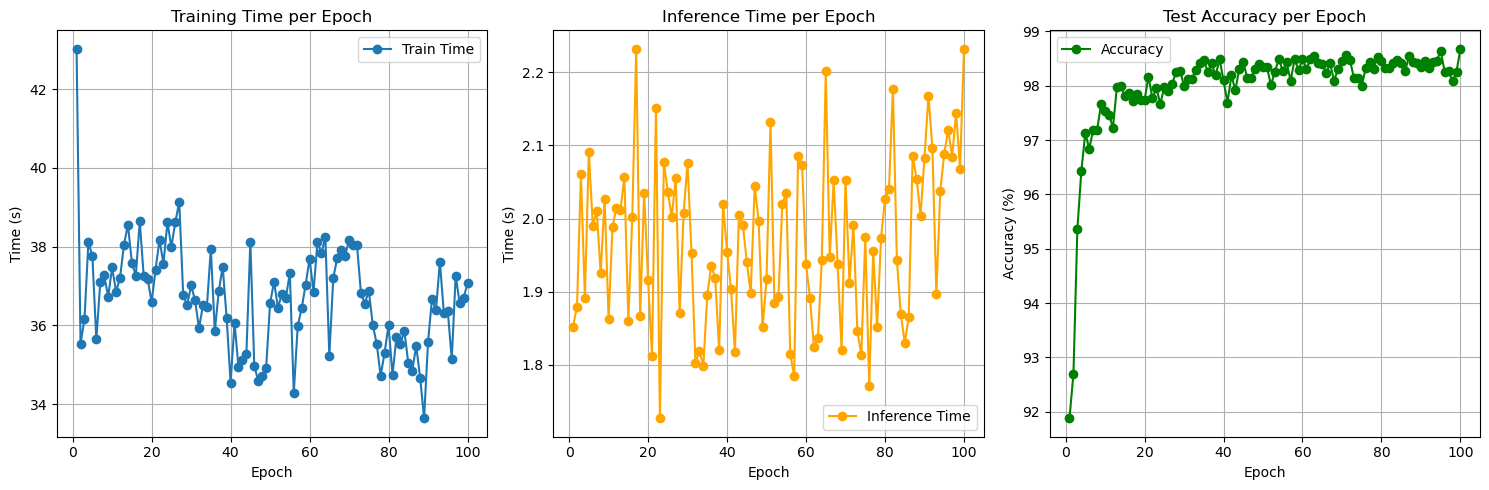

<Figure size 640x480 with 0 Axes>

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
import matplotlib.pyplot as plt

# Hyperparameter Definitions
image_size = 28  # MNIST image size
patch_size = 7   # Each image patch size (28 / 7 = 4 patches per side)
num_classes = 10  # MNIST has 10 classes
dim = 64         # Embedding dimension
depth = 4        # Transformer Block depth
num_heads = 4    # Multi-head attention heads
mlp_dim = 128    # Feedforward network hidden layer size
channels = 1     # Grayscale
batch_size = 64  # Batch size
epochs = 100     # Training epochs
learning_rate = 1e-3  # Learning rate
checkpoint_path = "teachers' performer_combined with vit_visualizationandcheckpointadded_MNIST_plus_time.h5"  # Model checkpoint path
csv_log_path = "teachers' performer_combined with vit_visualizationandcheckpointadded_MNIST_plus_time.csv"  # CSV log file path

# Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and Normalize Data
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0  # Normalize to [0, 1]
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0    # Normalize to [0, 1]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define Vision Transformer Model (Assuming VisionTransformer class is defined)
vit_model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    channels=channels,
)

# Check for Existing Checkpoint
try:
    vit_model.load_weights(checkpoint_path)
    print(f"Checkpoint loaded from {checkpoint_path}")
except Exception as e:
    print(f"No checkpoint found. Training from scratch.")

# Compile the Model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Initialize lists to store metrics
train_times = []
inference_times = []
accuracies = []

# Custom Callback to log metrics
class CustomMetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        # Calculate training time
        train_time = time.time() - self.epoch_start_time
        train_times.append(train_time)
        
        # Evaluate on the test set
        start_infer_time = time.time()
        test_loss, test_accuracy = vit_model.evaluate(x_test, y_test, verbose=0)
        infer_time = time.time() - start_infer_time
        inference_times.append(infer_time)
        accuracies.append(test_accuracy * 100)  # Convert to percentage
        
        # Print metrics
        print(f"Epoch {epoch + 1}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}, "
              f"Training Time = {train_time:.2f}s, Inference Time = {infer_time:.2f}s")

# Define Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    CustomMetricsLogger()
]

# Train the Model
vit_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=callbacks
)

# Plotting the Graphs
num_epochs = epochs  # Total number of epochs

plt.figure(figsize=(15, 5))

# Plot Training Time per Epoch
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_times, marker='o', label='Train Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Training Time per Epoch")
plt.grid(True)
plt.legend()

# Plot Inference Time per Epoch
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), inference_times, marker='o', color='orange', label='Inference Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Inference Time per Epoch")
plt.grid(True)
plt.legend()

# Plot Test Accuracy per Epoch
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.savefig("teachers' performer_combined with vit_visualizationandcheckpointadded_MNIST_plus_time.png")
plt.show()